In [1]:
! pip install snntorch

  Obtaining dependency information for snntorch from https://files.pythonhosted.org/packages/4b/55/95ee9e0e26cf74a464603ef7ab84be186133bfb95ac0c5ae9d1eb408b69b/snntorch-0.7.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nir from https://files.pythonhosted.org/packages/a8/e1/60b9014266c26d170b2f1bc7fe1b7b6ad823ad8cb302104ca306685311ac/nir-1.0.1-py3-none-any.whl.metadata
  Obtaining dependency information for nirtorch from https://files.pythonhosted.org/packages/cd/74/92cc684fd83636b072318693676877af0d80c4e136067237f147f9a18d6f/nirtorch-1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 109.0/109.0 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 8.9 MB/s eta 0:00:00


In [2]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split

import snntorch as snn
from snntorch import utils
from snntorch import surrogate

import numpy as np
import torch.optim as optim

In [35]:
class HybridSNNANN(nn.Module):
    def __init__(self, beta, thresh, latent_dim, num_steps):
        super(HybridSNNANN, self).__init__()
        self.num_steps = num_steps

        # SNN Encoder
        self.snn_encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1, stride=2),  # Changed output channels to 64
            nn.BatchNorm2d(64),  # Adjusted to match the output channels of the previous layer
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(64, 128, 3, padding=1, stride=2),  # Adjusted input and output channels
            nn.BatchNorm2d(128),  # Adjusted to match output channels
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Conv2d(128, 256, 3, padding=1, stride=2),  # Adjusted input and output channels
            nn.BatchNorm2d(256),  # Adjusted to match output channels
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True),
            nn.Flatten(),
            nn.Linear(256 * 8 * 8, latent_dim),  # Adjusted to match the flattened size
            snn.Leaky(beta=beta, threshold=thresh, init_hidden=True, output=True)
        )

        # ANN Decoder
        self.ann_decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),  # Adjusted to match the flattened size
            nn.ReLU(),
            nn.Unflatten(1, (256, 8, 8)),  # Adjusted to match the unflattened size
            nn.ConvTranspose2d(256, 128, 3, padding=1, stride=2, output_padding=1),  # Adjusted channels
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3, padding=1, stride=2, output_padding=1),  # Adjusted channels
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 3, padding=1, stride=2, output_padding=1),  # Output channels set to 1
            nn.Sigmoid()
        )


    def forward(self, x):
        # Reset states
        utils.reset(self.snn_encoder)
        utils.reset(self.ann_decoder)

        # Encode
        spk_rec = []
        mem_rec = []
        spike_data = []  # To store spike data
        
        for step in range(self.num_steps):
            spk_x, mem_x = self.snn_encoder(x) # spikes, membrane potential
            spk_rec.append(spk_x)
            mem_rec.append(mem_x)
            spike_data.append(spk_x.detach().cpu().numpy())  # Store spike data
        spk_rec = torch.stack(spk_rec, dim=2)
        mem_rec = torch.stack(mem_rec, dim=2) 
            # combines a list of tensors representing membrane potentials at different time steps into a single tensor. 
            #It adds a new dimension at the third position (dim=2), effectively creating a 3D tensor 

        # Decode
        decoded_x = []
        for step in range(self.num_steps):
            x_recon = self.ann_decoder(mem_rec[..., step]) #  2D slices of the 3D data at each iteration of the loop
            decoded_x.append(x_recon)
        decoded_x = torch.stack(decoded_x, dim=4)

        out = decoded_x[:,:,:,:,-1]  # Taking the output at the last time step
        return out, spike_data  # Return the output and spike data

In [36]:
def train(model, device, train_loader, optimizer, criterion, epoch):
    model.train()
    total_loss = 0.0

    for batch_idx, (data, _) in enumerate(train_loader):  # Ignore original labels
        data = data.to(device)
        optimizer.zero_grad()
        output, train_spike_data = model(data)
        loss = criterion(output, data)  # Compare output with the input image
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(train_loader)
    return average_loss, train_spike_data

# Validation function
def validate(model, device, val_loader, criterion):
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0

    with torch.no_grad():  # Disable gradient calculation
        for batch_idx, (data, _) in enumerate(val_loader):
            data = data.to(device)
            output, val_spike_data = model(data)
            loss = criterion(output, data)
            val_loss += loss.item()

    average_val_loss = val_loss / len(val_loader)
    return average_val_loss, val_spike_data

In [37]:
# Parameters
batch_size = 128
input_size = 64
train_split = 0.8
val_split = 0.1
test_split = 0.1

# Transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((input_size, input_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Load Dataset
caltech_data = datasets.ImageFolder(root='/kaggle/input/caltech101', transform=transform)

# Calculate split sizes
total_size = len(caltech_data)
train_size = int(total_size * train_split)
val_size = int(total_size * val_split)
test_size = total_size - train_size - val_size

# Split the dataset
train_dataset, val_dataset, test_dataset = random_split(caltech_data, [train_size, val_size, test_size])

# Data Loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [38]:
# Parameters and Run training and testing

# Initialize the model
beta = 0.5
thresh = 1.0
latent_dim = 256
num_steps = 10
model = HybridSNNANN(beta, thresh, latent_dim, num_steps)



#setup GPU
dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using device: {device}")
model = model.to(device)

# Define the optimizer and loss function
optimizer = optim.Adam(model.parameters())
criterion = nn.MSELoss()  # Assuming MSE loss, adjust as per your requirement

Using device: cuda


<class 'torch.Tensor'>
torch.Size([128, 1, 64, 64])
torch.Size([128])
(64, 64)


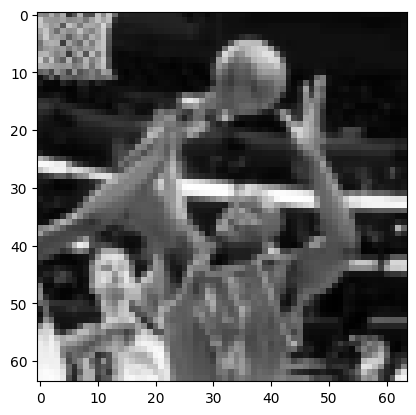

In [39]:
import matplotlib.pyplot as plt
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)
#Printing the size of one image
print(images[1].numpy().squeeze().shape)

plt.imshow(images[1].numpy().squeeze(), cmap='Greys_r');

In [41]:
import time

# Training loop    
train_losses = []
train_spikes = []
val_losses = []
val_spikes = []

num_epochs = 50
# Early Stopping parameters
patience = 5
best_val_loss = float('inf')
patience_counter = 0

start_time = time.time()  # Record the start time of the training

for epoch in range(num_epochs):
    epoch_start_time = time.time()  # Start time of the epoch

    train_loss, train_spike_data = train(model, device, train_loader, optimizer, criterion, epoch)
    train_losses.append(train_loss)
    train_spikes.append(train_spike_data)
    # Training loop with early stopping
    # Validation phase
    val_loss, val_spike_data = validate(model, device, val_loader, criterion)
    val_losses.append(val_loss)
    val_spikes.append(val_spike_data)
    
    print(f'Epoch {epoch},Training Loss: {train_loss:.4f},Validation Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
    else:
        patience_counter += 1
    
    if patience_counter >= patience:
        print("Early stopping triggered")
        break
    

end_time = time.time()  # Record the end time of the training
print(f"Training completed in {end_time - start_time:.2f} seconds.")

Epoch 0,Training Loss: 0.1875,Validation Loss: 0.1728
Epoch 1,Training Loss: 0.1728,Validation Loss: 0.1660
Epoch 2,Training Loss: 0.1670,Validation Loss: 0.1628
Epoch 3,Training Loss: 0.1623,Validation Loss: 0.1593
Epoch 4,Training Loss: 0.1595,Validation Loss: 0.1571
Epoch 5,Training Loss: 0.1577,Validation Loss: 0.1569
Epoch 6,Training Loss: 0.1560,Validation Loss: 0.1537
Epoch 7,Training Loss: 0.1541,Validation Loss: 0.1527
Epoch 8,Training Loss: 0.1530,Validation Loss: 0.1519
Epoch 9,Training Loss: 0.1517,Validation Loss: 0.1511
Epoch 10,Training Loss: 0.1513,Validation Loss: 0.1512
Epoch 11,Training Loss: 0.1507,Validation Loss: 0.1510
Epoch 12,Training Loss: 0.1504,Validation Loss: 0.1497
Epoch 13,Training Loss: 0.1490,Validation Loss: 0.1491
Epoch 14,Training Loss: 0.1487,Validation Loss: 0.1492
Epoch 15,Training Loss: 0.1482,Validation Loss: 0.1492
Epoch 16,Training Loss: 0.1480,Validation Loss: 0.1481
Epoch 17,Training Loss: 0.1475,Validation Loss: 0.1484
Epoch 18,Training Lo

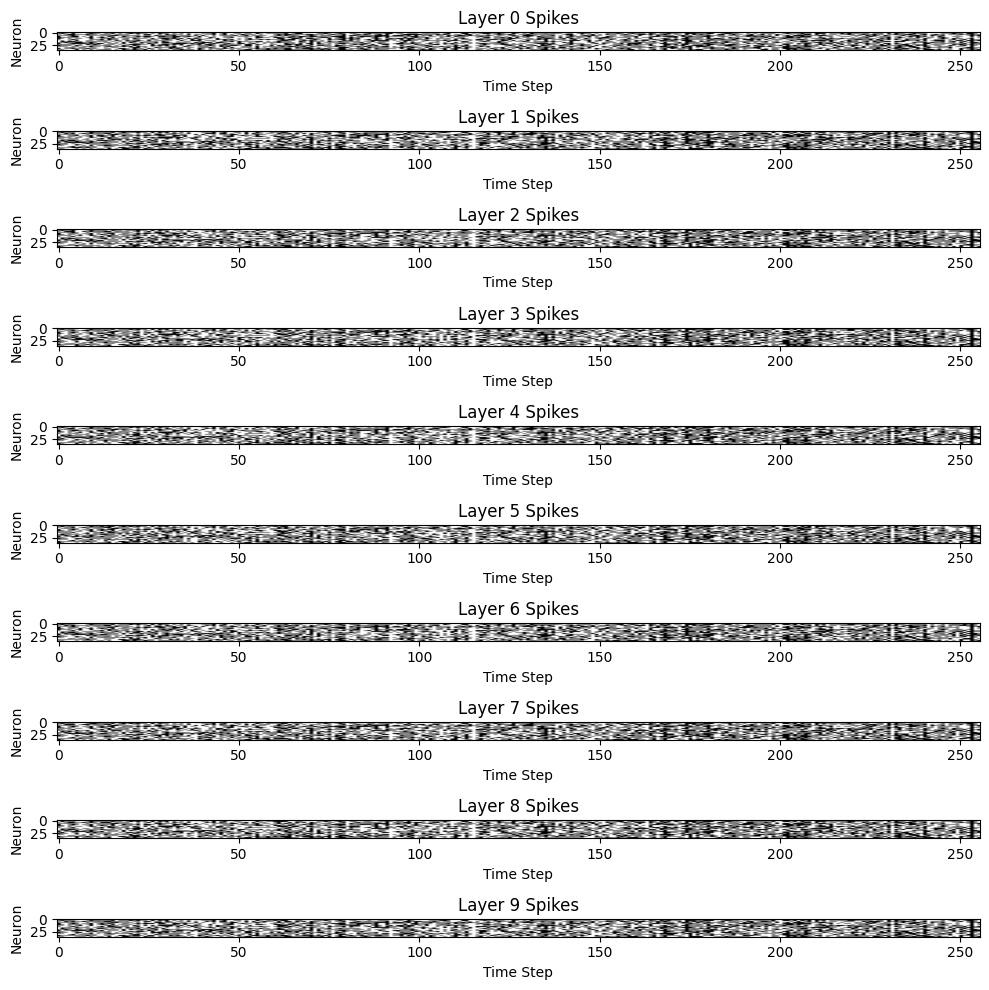

In [54]:
# Spike data visualization
plt.figure(figsize=(10, 10))
for i, spikes in enumerate(val_spike_data):
    plt.subplot(len(val_spike_data), 1, i + 1)
    plt.imshow(spikes, cmap='binary', aspect='auto')
    plt.title(f"Layer {i} Spikes")
    plt.ylabel("Neuron")
    plt.xlabel("Time Step")

plt.tight_layout()
plt.show()

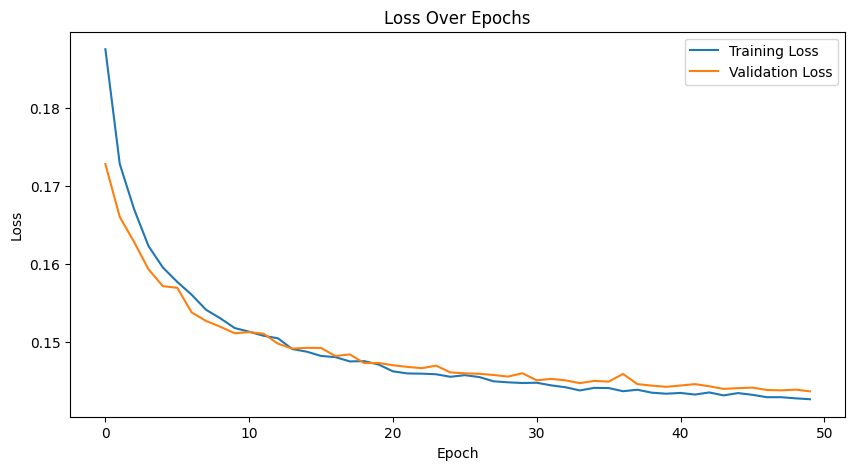

In [44]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [45]:
# Calculate the average loss for the entire test set
total_loss = 0

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        output, test_spike_data = model(data)
        loss = criterion(output, data)
        total_loss += loss.item()

avg_loss = total_loss / len(test_loader)
print(f'Test set: Average loss: {avg_loss:.4f}')

Test set: Average loss: 0.1345


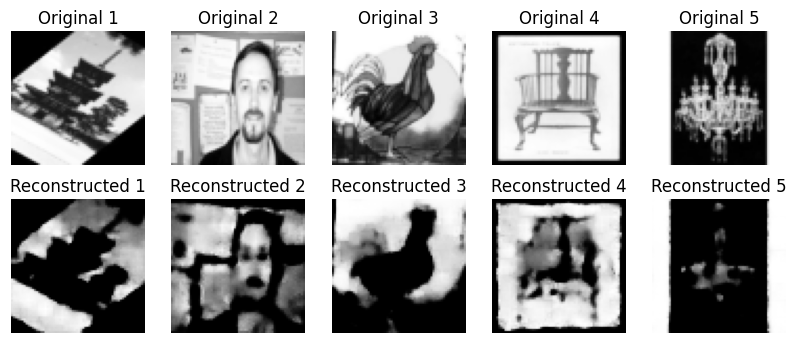

In [47]:
import matplotlib.pyplot as plt
import torch

# Get some test data for visualization
dataiter = iter(test_loader)
images, _ = next(dataiter)
images = images.to(device)

# Get the output from the model for these images
with torch.no_grad():
    model.eval()
    outputs,_ = model(images)

# Convert images and outputs to CPU for plotting if running on GPU
images = images.cpu()
outputs = outputs.cpu()

# Plot the first few images and their reconstructions
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 4))
for i in range(5):
    # Display original images
    ax = axes[0, i]
    ax.imshow(images[i].squeeze(), cmap='Greys_r')
    ax.set_title(f'Original {i+1}')
    ax.axis('off')

    # Display reconstructed images
    ax = axes[1, i]
    ax.imshow(outputs[i].squeeze(), cmap='Greys_r')
    ax.set_title(f'Reconstructed {i+1}')
    ax.axis('off')

plt.show()